# Text Emotion Detector using LSTM
---

### 6 Emotion Classes

- **0** -> sadness  
- **1** -> joy  
- **2** -> love  
- **3** -> anger  
- **4** -> fear  
- **5** -> surprise


## Loading Dataset

In [33]:
import pandas as pd
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset

# Load dataset
dataset = load_dataset("dair-ai/emotion", split="train").train_test_split(test_size=0.2, seed=42)
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['test'])

## Preprocessing

In [34]:
lemmatizer = WordNetLemmatizer()

def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

df_train['clean_text'] = df_train['text'].apply(clean_and_lemmatize)
df_val['clean_text'] = df_val['text'].apply(clean_and_lemmatize)

# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train['label'].astype(str))  
y_train = le.transform(df_train['label'].astype(str))
y_val = le.transform(df_val['label'].astype(str))

# Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Tokenization + Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['clean_text'])

X_train = tokenizer.texts_to_sequences(df_train['clean_text'])
X_val = tokenizer.texts_to_sequences(df_val['clean_text'])

X_train = pad_sequences(X_train, maxlen=100)
X_val = pad_sequences(X_val, maxlen=100)

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

## Visualization (Frequency bar graph and Word cloud)

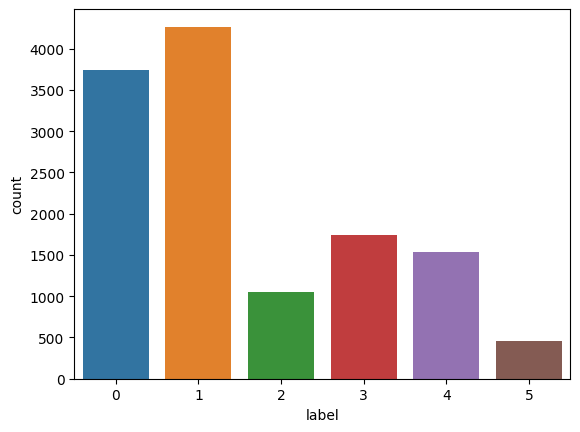

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_train, x='label')
plt.show()

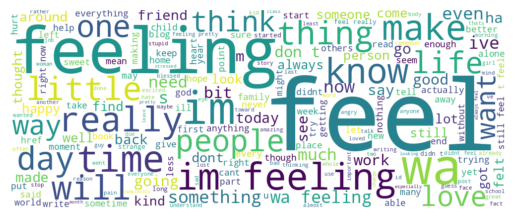

In [36]:
from wordcloud import WordCloud

text = ' '.join(df_train['clean_text'])
wc = WordCloud(width=1000, height=400, background_color='white').generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Model

In [37]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

model.save("lstm_emo_model.h5")

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3339 - loss: 1.6164 - val_accuracy: 0.6772 - val_loss: 0.8810
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7572 - loss: 0.7008 - val_accuracy: 0.8878 - val_loss: 0.3531
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9237 - loss: 0.2521 - val_accuracy: 0.8556 - val_loss: 0.4225
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9466 - loss: 0.1766 - val_accuracy: 0.9091 - val_loss: 0.2756
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9621 - loss: 0.1252 - val_accuracy: 0.9041 - val_loss: 0.3241


## Evaluation

In [38]:
from sklearn.metrics import classification_report,accuracy_score

y_pred = model.predict(X_val).argmax(axis=1)
print(f"Validation Accuracy={accuracy_score(y_pred,y_val)*100:.2f} %")
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=[str(label) for label in le.classes_]))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy=90.41 %

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       924
           1       0.93      0.93      0.93      1096
           2       0.80      0.78      0.79       249
           3       0.88      0.91      0.90       416
           4       0.87      0.83      0.85       400
           5       0.78      0.70      0.73       115

    accuracy                           0.90      3200
   macro avg       0.87      0.85      0.86      3200
weighted avg       0.90      0.90      0.90      3200

